# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: December 28, 2023 

Given the analytical equation (fitted empirically) for the Drag Coefficient $C_D$ provided in reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf, we see that it's only a function of the Reynolds number, $Re = \rho.U.D/\mu$. Let's say that we did not know this ahead of time and wanted to perform experiments for a range of input parameters, namely, $\rho$, $U$, $D$, and $\mu$. Clearly, many combinations will be redundant since they correpond to the same $Re$. Consider the following models:  

Given $\rho$, $U$, $D$, and $\mu$, consider the following two models:  



<img src="./Figures/Model_I.png" width="300" height="200" /> . 
<img src="./Figures/Model_II.png" width="300" height="200" /> . 

We are interested in the following questions:  
1. Assuming we keep the number of trainable parameters approximately the same, is Model_I more data efficient than Model_II, if we randomly sample the 4 parameters?  Intuitively, we expect this to be true since we are biasing the structure of the neural network to discover the existence of an effective compression of the inputs (by $Re$).  
2. After training Model_I, does the single node actually correspond to $Re$? Can the model 'discover' the non-dimensional parameters?  If not, can we somehow help the model to discover this?  
3. (Optional) can we use the knowledge of the $Re$ to perform data augmentation thereby increasing the efficiency of the training? For example, given a combination of inputs, we could generate $n$ additional training samples corresponding to the same $Re$. This 'synthetic data' is expected to improve the efficiency. It is not clear whether this is useful in practice. Still interesting to explore.  





In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

matplotlib.rcParams.update({'font.size': 18})
eps = 1e-12

In [2]:
def CD_calc(Re=None, U=None, D=None, rho=None, mu=None):
    """
    Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
    reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf

    Use SI units

    """
    if Re is None:
        Re = rho*U*D/mu

    CD = (24/Re) \
        + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
        + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
        + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

    # Calculate FD if U and D and rho are given:
    if U is not None:
        FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
    else:
        FD = None

    return CD, FD


def run_experiments(Re_vec, velocities=None, diameters=None, densities=None, viscosities=None):
    """
    Runs the experiment by iterating over the velocity vector or Re_vec and returning the drag coefficient CD and Drag force FD

    """
    if Re_vec is not None:
        CDs, FDs = CD_calc(Re=Re_vec, rho=None, mu=None, U=None, D=None)
    else:
        CDs, FDs = CD_calc(Re=None, U=velocities, D=diameters, rho=densities, mu=viscosities)

    return CDs, FDs


def plot_CD(Re, CD, marker='o'):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=Re, y=CD, color='blue', marker=marker, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1, 1e11)
    plt.ylim(1e-2, 1e3)
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')

    return True

def generate_inputs_from_Re(Re_vec, u_range, rho_range, mu_range, D_range):
    """
    Randomly sample from rho_range, mu_range, and D_range, calculate u, if u is in u_range, 
    output the parameters, u, rho, mu, D and if not, sample again and repeat. This is used to test inference.
    """
    # Generate random samples from the ranges
    size = len(Re_vec)
    rho = np.random.uniform(rho_range[0], rho_range[1], size)
    mu = np.random.uniform(mu_range[0], mu_range[1], size)
    D = np.random.uniform(D_range[0], D_range[1], size)
    U = Re_vec * mu / (rho * D)

    for u in U:
        if u >= u_range[1] and u <= u_range[0]:
            print(f"U = {u} is NOT in range")

    return rho, mu, D, U

In [3]:
Re_vec = np.logspace(-1, 9, 1000)
rho, mu, D, U = generate_inputs_from_Re(Re_vec=Re_vec, u_range=[0.1, 1e3], rho_range=[1, 1000], mu_range=[1e-3, 1e3], D_range=[1e-3, 1e3])
# rho

True

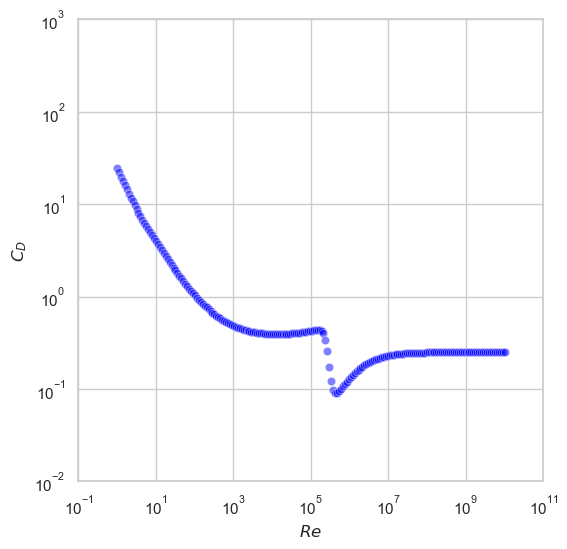

In [4]:
Re_vec = np.logspace(0, 10, 200)
CDs, _ = run_experiments(Re_vec=Re_vec)
plot_CD(Re_vec, CDs, marker='o')

## Models

In [5]:
# Model_II
class Model_II(nn.Module):
    def __init__(self, input_dim=4 , output_dim= 1, hidden_dims=[32, 16, 8, 4]):
        super(Model_II, self).__init__()
        hidden_dims.insert(0, input_dim)
        hidden_dims.append(output_dim)
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            # x = torch.relu(self.layers[i](x))
            x = F.leaky_relu(self.layers[i](x), 0.1)
        x = self.layers[-1](x)  # Apply the last layer without ReLU
        return x

## Dataset Creation

In [7]:
# Data Generation:
# Let's first generate random samples of rho, mu, D, and U. The true label is then calculated using the run_experiments function. 
# The Reynolds numbers are also calculated and returned as a vector for convenience.
def sample_parameters(num_samples=10000, rho_range=[10, 2000], mu_range=[0.001, 0.1], D_range=[0.05, 0.5], U_range=[0.01, 20], seed=123):
    if seed is not None:
        np.random.seed(seed)
        
    rho = np.random.uniform(rho_range[0], rho_range[1], num_samples)
    mu = np.random.uniform(mu_range[0], mu_range[1], num_samples)
    D = np.random.uniform(D_range[0], D_range[1], num_samples)
    U = np.random.uniform(U_range[0], U_range[1], num_samples)

    # Calculate the true CD and FD:
    CD, _ = run_experiments(Re_vec=None, velocities=U, diameters=D, densities=rho, viscosities=mu)
    Re_vec = rho * U * D / mu
    return rho, mu, D, U, Re_vec, CD

class RandomDataset(Dataset):
    def __init__(self, num_samples=10000, rho_range=[100, 2000], mu_range=[0.001, 0.01], D_range=[0.05, 0.5], U_range=[0.1, 20], seed=None):
        self.rho, self.mu, self.D, self.U, self.Re, self.CD = sample_parameters(num_samples=num_samples, rho_range=rho_range, mu_range=mu_range, D_range=D_range, U_range=U_range, seed=seed)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_sample = np.array([self.rho[idx], self.mu[idx], self.D[idx], self.U[idx]], dtype=np.float32)
        target = np.array([self.CD[idx]], dtype=np.float32)
        return input_sample, target


# Create the dataloader/dataset:
dataset = RandomDataset(num_samples=20000, rho_range=[10, 2000], mu_range=[1e-3, 0.1], D_range=[0.05, 0.5], U_range=[0.01, 20], seed=123)


# Split the dataset into train, validation, and test sets:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0) #TODO: Change num_workers to 4. Need to take RandomDataset out of the main function
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)


# Training

In [8]:
# Setting up the model:
model = Model_II(input_dim=4, output_dim=1, hidden_dims=[64, 32, 32, 32, 4])
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

model = model.float()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter('runs/Model_II')

NUM_EPOCHS = 5000

Number of trainable parameters: 4649


In [9]:
# Used to save the best model:
best_val_loss = float('inf')
best_model_state = None

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    writer.add_scalar('Loss/Train', train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    tqdm.write(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Test loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
writer.add_scalar('Loss/Test', test_loss, NUM_EPOCHS)

tqdm.write(f'Final Test Loss: {test_loss:.4f}')

# Save the best model:
torch.save(best_model_state, 'models/Model-II-checkpoint.pth')
writer.close()

Epoch 1/5000, Train Loss: 0.7942, Validation Loss: 0.0615
Epoch 2/5000, Train Loss: 0.0414, Validation Loss: 0.0112
Epoch 3/5000, Train Loss: 0.0252, Validation Loss: 0.0111
Epoch 4/5000, Train Loss: 0.0250, Validation Loss: 0.0112
Epoch 5/5000, Train Loss: 0.0249, Validation Loss: 0.0111
Epoch 6/5000, Train Loss: 0.0249, Validation Loss: 0.0111
Epoch 7/5000, Train Loss: 0.0249, Validation Loss: 0.0111
Epoch 8/5000, Train Loss: 0.0248, Validation Loss: 0.0111
Epoch 9/5000, Train Loss: 0.0248, Validation Loss: 0.0110
Epoch 10/5000, Train Loss: 0.0248, Validation Loss: 0.0110
Epoch 11/5000, Train Loss: 0.0247, Validation Loss: 0.0110
Epoch 12/5000, Train Loss: 0.0247, Validation Loss: 0.0110
Epoch 13/5000, Train Loss: 0.0247, Validation Loss: 0.0109
Epoch 14/5000, Train Loss: 0.0247, Validation Loss: 0.0109
Epoch 15/5000, Train Loss: 0.0246, Validation Loss: 0.0109
Epoch 16/5000, Train Loss: 0.0246, Validation Loss: 0.0109
Epoch 17/5000, Train Loss: 0.0246, Validation Loss: 0.0109
Epoch 

## Inference & Testing:  
Visualize the model fit by looking at the curves for a regularly-spaced Re vector covering the entire range.

In [10]:
def infer_cd_from_re(re_vector, model_path):
    model_checkpoint = torch.load(model_path)
    model = Model_II(input_dim=4, output_dim=1, hidden_dims=[64, 32, 32, 32, 4])
    model.load_state_dict(model_checkpoint)
    model.eval()

    # Generate inputs from Re
    rho, mu, D, U = generate_inputs_from_Re(Re_vec=re_vector,  # Corrected variable name
                                            u_range=[0.01, 20],
                                            rho_range=[10, 2000],
                                            mu_range=[1e-3, 0.1],
                                            D_range=[0.05, 0.5])

    # Prepare the input tensor
    input_tensor = torch.tensor(np.column_stack((rho, mu, D, U)), dtype=torch.float32)

    # Perform inference
    with torch.no_grad():
        cd_predicted = model(input_tensor).squeeze().numpy()

    return cd_predicted


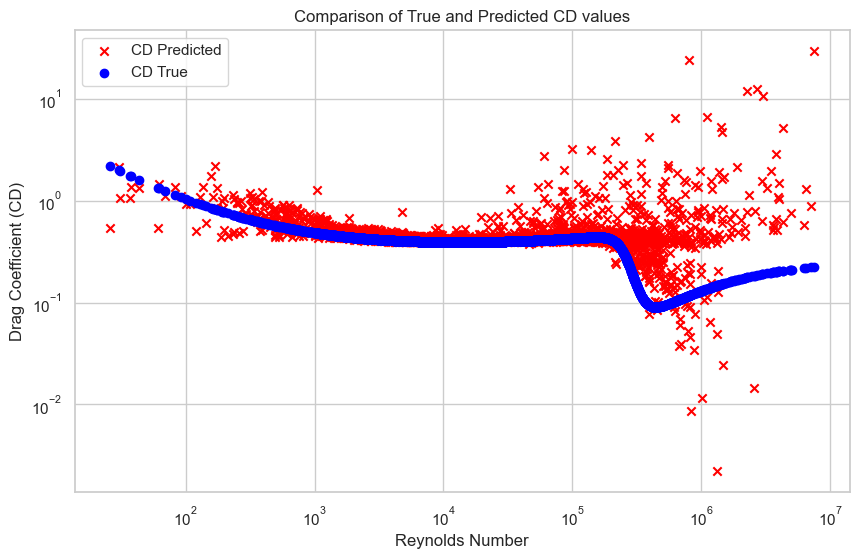

MSE: 0.43703477408299585


In [11]:
rho, mu, D, U, Re_vec, CD = sample_parameters(num_samples=5000, 
                                              rho_range=[10, 2000], 
                                              mu_range=[0.001, 0.1], 
                                              D_range=[0.05, 0.5], 
                                              U_range=[0.01, 20])

cd_predicted = infer_cd_from_re(re_vector=Re_vec, model_path='models/Model-II-checkpoint.pth')
cd_true = CD

plt.figure(figsize=(10, 6))

plt.scatter(Re_vec, cd_predicted, color='red', label='CD Predicted', marker='x')
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o')
plt.xscale('log')
plt.yscale('log')


plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()
plt.show()

mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)


In [ ]:
Re_vec[0:10]

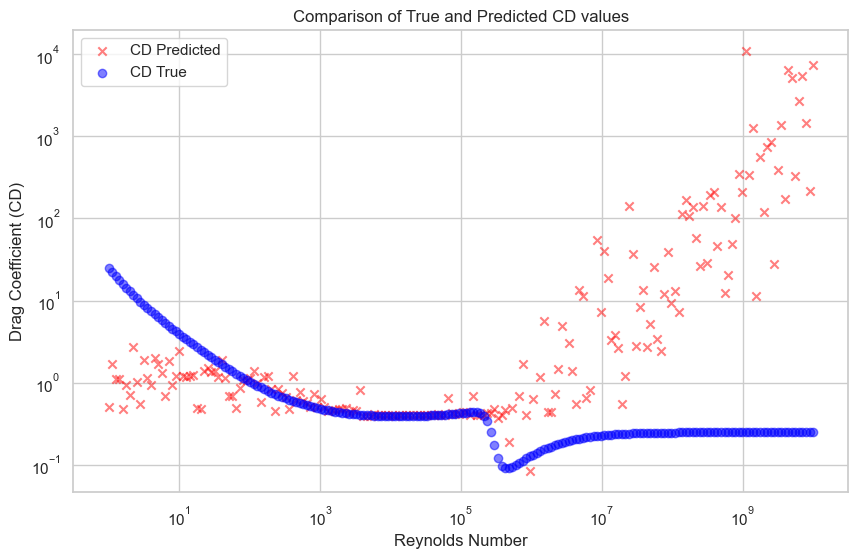

MSE: 1419907.8290532585


In [13]:
# Testing:
# Generate a random Re vector:
Re_vec = np.logspace(0, 10, 200)
# Re_vec = np.logspace(-1, 11, 5000)
# Infer the CD from the Re vector:
cd_predicted = infer_cd_from_re(Re_vec, model_path='models/Model-II-checkpoint.pth')
cd_true, _ = run_experiments(Re_vec=Re_vec)

plt.figure(figsize=(10, 6))

# Plotting predicted CD values
plt.scatter(Re_vec, cd_predicted, color='red', label='CD Predicted', marker='x', alpha=0.5)
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

# plt.ylim(1e-16, 1e8)


# plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()

plt.show()


mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)

## Experiments:
Generating some 'experimental' data and comparing different $\Pi$ groups

### Material parameters:

In [ ]:
# Let's take water as an example: rho = 1000Kg/m^3, mu = 0.001 Ns/M^2
# c_sound (Cs) in water ~ 1481 m/s, Cs(Acetone) = ~1100 m/s - We need to make sure the velocity is < 0.3*Cs
N = 200 # Number of samples
Cs = 1481 # m/s
u_max = 0.3 * Cs # Picked 0.2 to make sure the condition is not violated for acetone

mu_water = 0.001 # [SI]
rho_water = 1000 # [SI]

mu_acetone = 0.000316 # Acetone [SI]
rho_acetone = 784.5 # Acetone [SI]

# Sphere diameters:
D_I = 0.05 # Diameter of sphere
D_II = 0.1
D_III = 0.5

### Setting up the 'Experiments':

In [ ]:
# Let's keep the velocities the same for now:
us = np.geomspace(0.001, u_max, N)

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)
fig, ax1, ax2 = make_plots(Re=REs_2, CD=CDs_2, FD=FDs_2, experiment_id='Experiment-1 and 2', colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2)

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)
fig, ax1, ax2 = make_plots(Re=REs_3, CD=CDs_3, FD=FDs_3, experiment_id='Experiment-3', colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2)

### Comparing to other $\Pi$ groups:
It appears $\Pi_4$ does not work but the rest do! Why??

In [ ]:
# Comparing the following Pi group:

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
# fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1', colors=['blue', 'blue'])

pi2_1 = [FDs/(mu_1*D_1*uu) for (FDs, uu) in zip(FDs_1, us)]
pi3_1 = [FDs*rho_1/mu_1**2 for FDs in FDs_1]

fig, ax1, ax2 = make_plots(Re=REs_1, CD=pi2_1, FD=FDs_1, experiment_id='Experiment-1', 
                           colors=['blue', 'blue'], ylabel='$\Pi_2$')

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)

pi2_2 = [FDs/(mu_2*D_2*uu) for (FDs, uu) in zip(FDs_2, us)]
pi3_2 = [FDs*rho_2/mu_2**2 for FDs in FDs_2]

fig, ax1, ax2 = make_plots(Re=REs_2, CD=pi2_2, FD=FDs_2, experiment_id='Experiment-1 and 2', 
                           colors=['red', 'red'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)

pi2_3 = [FDs/(mu_3*D_3*uu) for (FDs, uu) in zip(FDs_3, us)]
pi3_3 = [FDs*rho_3/mu_3**2 for FDs in FDs_3]

fig, ax1, ax2 = make_plots(Re=REs_3, CD=pi2_3, FD=FDs_3, experiment_id='Experiment-3', 
                           colors=['green', 'green'], fig=fig, ax1=ax1, ax2=ax2, ylabel='$\Pi_2$')

Some more ideas discussed with Hamed (December 27th, 2020):
* Can we somehow use different units (e.g., SI vs imperial) to allow the network to learn the invariance to change of units?
* Explore online data collection...depending on the results of a given experiment, the network selects what data point is needed
* Can we use the knowledge of the number of possible dimensionless groups to create an appropriate architecture? For example, one simple way in this case is to use two nodes in the penultimate (or else) layer since we expect a simpler relationship between the two $\Pi$ groups. 

## Neural Net Regression
Method #1:  
$F_D$ = $f(\rho, \mu, U, D)$

Method #2:  
$F_D$ = $f(Re, \rho, U, D)$

Method #3:  
$C_D$ = $f(Re, \rho, U, D)$

For all three methods, we use a deep neural network to approximate the function $f$.

Method #4:
Now, let's say we somehow know that there are 2 dimensionless parameters. 'Design' the architecture (i.e., bottleneck), so that there are 2 bottleneck nodes before we estimate the $F_D$. Compare the values of the bottleneck nodes to the $Re$ and $C_D$. Is there a correspondence? if not, how can we nudge them to be??

### Dataset creation:

In [ ]:
# Uncomment the following if you want to re-generate the dataset. It takes a couple of minutes.

# # Picking some ranges for the parameters:
# N = 50 # Number of points
# mu_vec = np.linspace(0.0001, 0.01, N)
# rho_vec = np.linspace(500, 2000, N)
# U_vec = np.linspace(0.001, 200, 2*N)
# D_vec = np.linspace(0.01, 0.1, N)

# FDs = np.zeros((N, N, 2*N, N))
# CDs = np.zeros((N, N, 2*N, N))
# counter = 0
# X, Y = [], []
# for ii, m in enumerate(mu_vec):
#     for jj, r in enumerate(rho_vec):
#         for kk, u in enumerate(U_vec):
#             for ll, d in enumerate(D_vec):
#                 CDs[ii, jj, kk, ll], FDs[ii, jj, kk, ll] = CD_calc(Re=None, U=u, D=d, rho=r, mu=m)
#                 X.append([m, r, u, d])
#                 Y.append(FDs[ii, jj, kk, ll])
                
# X = np.array(X)
# Y = np.array(Y)

In [ ]:
# Saving the generated data in the previous cell:
# with open('dataset1.npy', 'wb') as f:
#     np.save(f, mu_vec)
#     np.save(f, rho_vec)
#     np.save(f, U_vec)
#     np.save(f, D_vec)
#     np.save(f, CDs)
#     np.save(f, FDs)
#     np.save(f, X)
#     np.save(f, Y)
    
# Loading the saved generated data:
with open('dataset1.npy', 'rb') as f:
    mu_vec = np.load(f)
    rho_vec = np.load(f)
    U_vec = np.load(f)
    D_vec = np.load(f)
    CDs = np.load(f)
    FDs = np.load(f)
    X = np.load(f)
    Y = np.load(f)

In [ ]:
print(X.shape)
print(Y.shape)

### PyTorch Training:

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import imageio

In [ ]:
# np.max(Y)

In [ ]:
# Scale input variables so that they are roughly in the same range:
X[:,0] = X[:,0] * 1e4
X[:,1] = X[:,1] * 1e-2
X[:,2] = X[:,2] * 1e-1
X[:,3] = X[:,3] * 1e2

In [ ]:
torch.manual_seed(42)
# convert to tensors and then Variables
x_data, y_data = Variable(torch.tensor(X)), Variable(torch.tensor(Y))

In [ ]:
len(x_data)

### Define the Network:

In [ ]:
# METHOD #1:
# Dimensions of hidden units
D_in = 4 # mu, rho, U, D
H = [32, 16, 8] # 3 Hidden units
D_out = 1 # Drag force
model_1 = torch.nn.Sequential(torch.nn.Linear(D_in, H[0]), 
                              torch.nn.BatchNorm2d(H[0]),
                              torch.nn.ReLU(), 
                              torch.nn.Linear(H[0], H[1]),
                              torch.nn.BatchNorm2d(H[1]),
                              torch.nn.ReLU(),
                              torch.nn.Linear(H[1], H[2]),
                              torch.nn.BatchNorm2d(H[2]),
                              torch.nn.ReLU(), 
                              torch.nn.Linear(H[2], D_out))

In [ ]:
# Test running the model
x_test = X[0,:].astype('float32')
print(x_test)

x_test_torch = torch.tensor(x_test)
out_test = model_1(x_test_torch)

In [ ]:
# Hpyerparameters:
N = len(x_data) # number of training samples
learning_rate = 1e-5
batch_size = 100000
batches_per_epoch = N // batch_size
epochs = 1
max_batches = epochs * batches_per_epoch

# Loss function and optimizer
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

In [ ]:
# Training:
print("Start Training...")

for b in range(max_batches):
    curr_batch = np.random.choice(N, batch_size, replace=False)
    xx = torch.tensor(X[curr_batch].astype('float32'))
    yy = torch.tensor(Y[curr_batch].astype('float32')).view(batch_size, 1)
    
    # zero the gradients:
    optimizer.zero_grad()
    
    # Predict:
    y_pred = model_1(xx)
    
    # Calculate loss:
    loss = loss_fn(y_pred, yy)
    
    # Calculate gradients:
    loss.backward()
    
    # Step:
    optimizer.step()
    
    # Print out some metrics:
    if b % (max_batches // 10) == 0:
        print("batch = %6d" % b, end="")
        print("  batch loss = %7.4f" % loss.item(), end="")
        
print("Training complete \n")
    

In [ ]:
FDs

TODO: Figure out why NaNs are produced at the output....probably related to scaling of the variables. Use batchnorm?